# Imports 

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from phenoseeker import BioproxyEvaluator
import pandas as pd
from tqdm import tqdm

In [ ]:
 # To get those datas, see README.md 

screens_folders = {
 #   "Curie": Internal data, we can't share them
    "ChEMBL": Path("/projects/synsight/repos/phenoseeker/data/ChEMBL/assays_csv"),
    "Lit-PCBA": Path("/projects/synsight/repos/phenoseeker/data/Lit_PCBA/csv_files"),
}

In [ ]:
# Paht of created profiles (and metadata) from create_profile.py - see README

model = "openphenom"
base_path = Path("/projects/synsight/data/jump_embeddings/compounds_embeddings/")
npy_file = base_path / model / "Embeddings_norm.npy"
parquet_metadata = base_path / model / Path("metadata.parquet")

In [4]:
eval = BioproxyEvaluator(
    parquet_metadata,
    npy_file,
    screens_folders,
    embeddings_name=f"Embeddings_{model}",
    embeddings_entity="compound",
)

In [ ]:
eval

BioproxyEvaluator with 3 sources (Curie: 16 screens, ChEMBL: 49 screens, Lit-PCBA: 5 screens)

In [6]:
model = "dinov2_g"
npy_file = base_path / model / "Embeddings_norm.npy"
parquet_metadata = base_path / model / Path("metadata.parquet")
eval.load(
    embedding_name=f"Embeddings_{model}",
    embeddings_file=npy_file,
    metadata_file=parquet_metadata,
)

# Process Screen (Lit-PCBA & ChEMBL)

In [ ]:
chembl_results_of = eval.compute_enrichment_factors(
    source="ChEMBL", embeddings_name="Embeddings_openphenom", thresholds=[1, 3, 5, 10]
)
chembl_results_dino = eval.compute_enrichment_factors(
    source="ChEMBL", embeddings_name="Embeddings_dinov2_g", thresholds=[1, 3, 5, 10]
)

Processing ChEMBL screens: 100%|██████████| 49/49 [00:24<00:00,  1.97it/s]


In [ ]:
lit_pcba_results_of = eval.compute_enrichment_factors(
    source="Lit-PCBA", embeddings_name="Embeddings_openphenom", thresholds=[1, 3, 5, 10]
)
lit_pcba_results_dino = eval.compute_enrichment_factors(
    source="Lit-PCBA", embeddings_name="Embeddings_dinov2_g", thresholds=[1, 3, 5, 10]
)


Processing Lit-PCBA screens: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


# Clean figures

In [ ]:
def plot_result_model(df, threshold_value=5, figsize=(20, 10), plot_names=False):
    import numpy as np
    import matplotlib.pyplot as plt

    # Filter the dataframe
    df = df[df[("N Hits", "mean")] > 5]
    df_threshold = df[df[("Threshold", "")] == threshold_value].copy()
    df_threshold.sort_values(("Hit Rate Random", "mean"), inplace=True)

    x = np.arange(len(df_threshold))
    width = 0.25

    # Extract values
    baseline = df_threshold[("Hit Rate Random", "mean")] * 100
    mean_enrichment = df_threshold[("Normalized_EF", "mean")]
    max_enrichment = df_threshold[("Normalized_EF", "max")]

    # Colors in order: Purple, Green, Blue
    colors = {"baseline": "purple", "mean": "green", "max": "blue"}

    _, ax = plt.subplots(figsize=figsize)

    # Plot grouped bars
    ax.bar(
        x - width,
        baseline,
        width,
        color=colors["baseline"],
        label="Baseline: Original Selection of Compounds",
    )
    ax.bar(
        x,
        mean_enrichment,
        width,
        color=colors["mean"],
        label="Mean Enrichment Achieved by Our Method",
    )
    ax.bar(
        x + width,
        max_enrichment,
        width,
        color=colors["max"],
        label="Maximum Enrichment Achieved by Our Method",
    )

    # Adapt x-axis tick labels based on the plot_names flag
    ax.set_xticks(x)
    if plot_names:
        # Align labels to the right without rotation
        ax.set_xticklabels(df_threshold[("Screen", "")], rotation=0, ha="right")
    else:
        ax.set_xticklabels("", ha="right")

    # Remove axis labels
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Add grid for better readability
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    # Increase the font size of both x and y axis tick labels
    ax.tick_params(axis="y", labelsize=20)
    ax.tick_params(axis="x", labelsize=20)

    plt.tight_layout()
    plt.show()

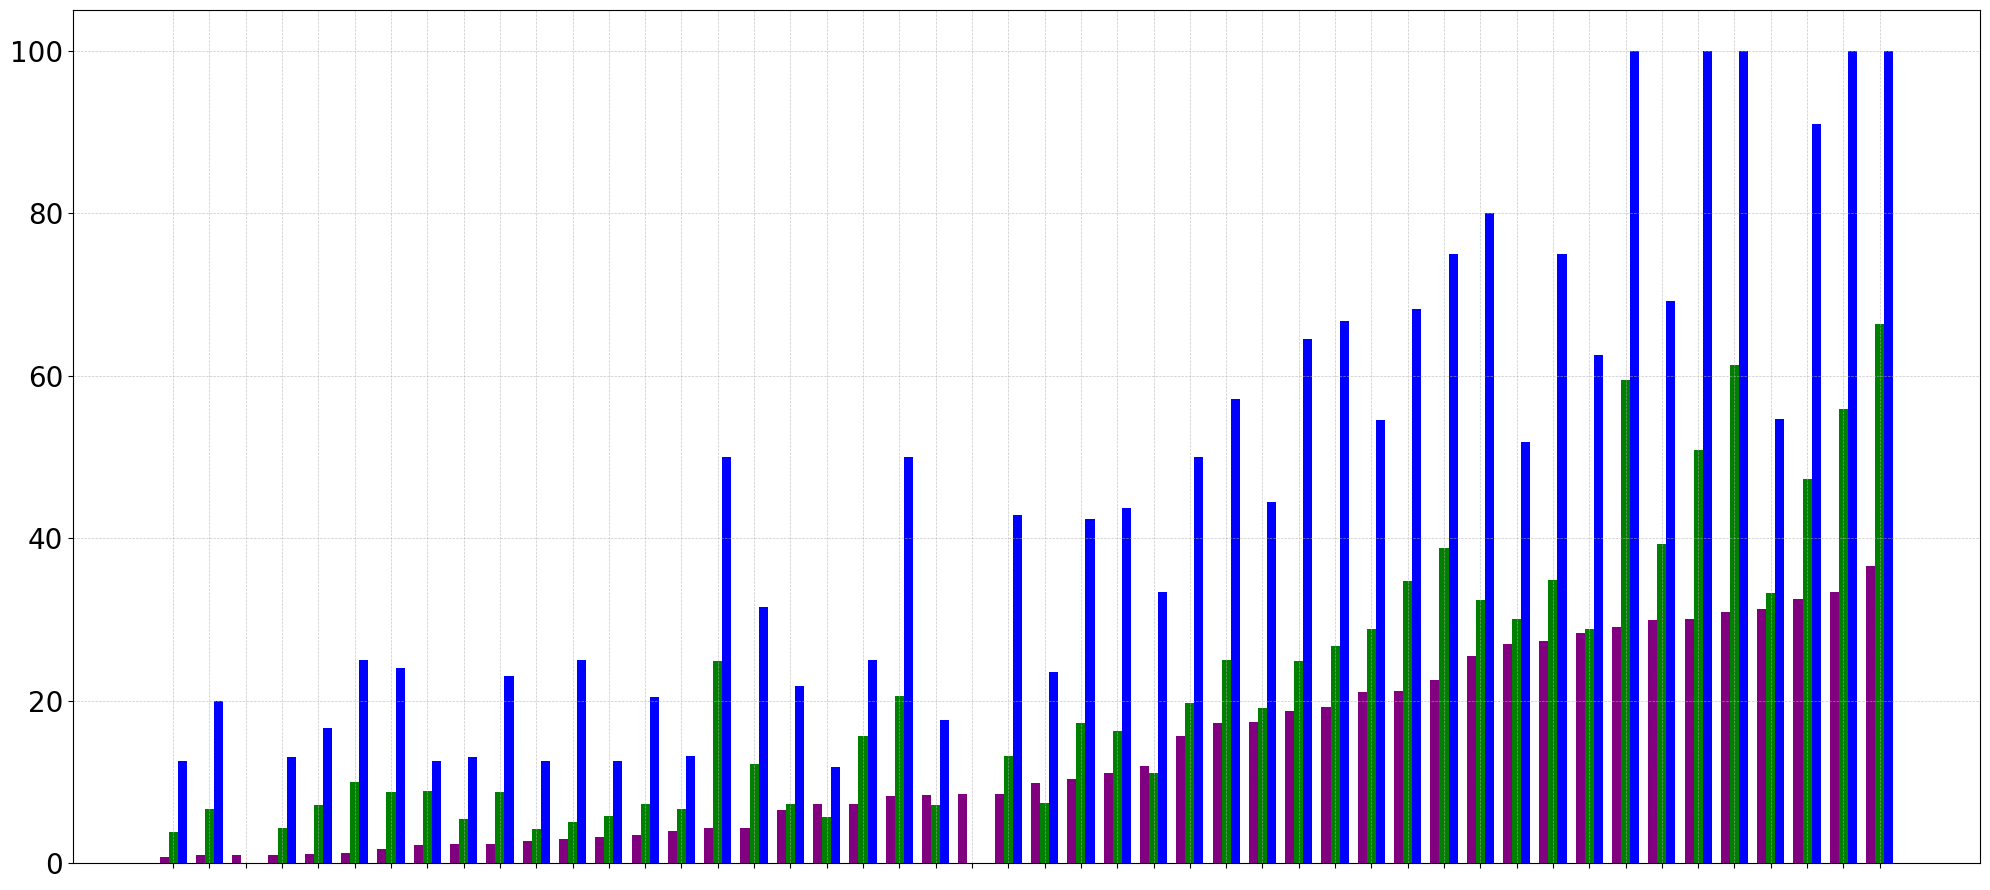

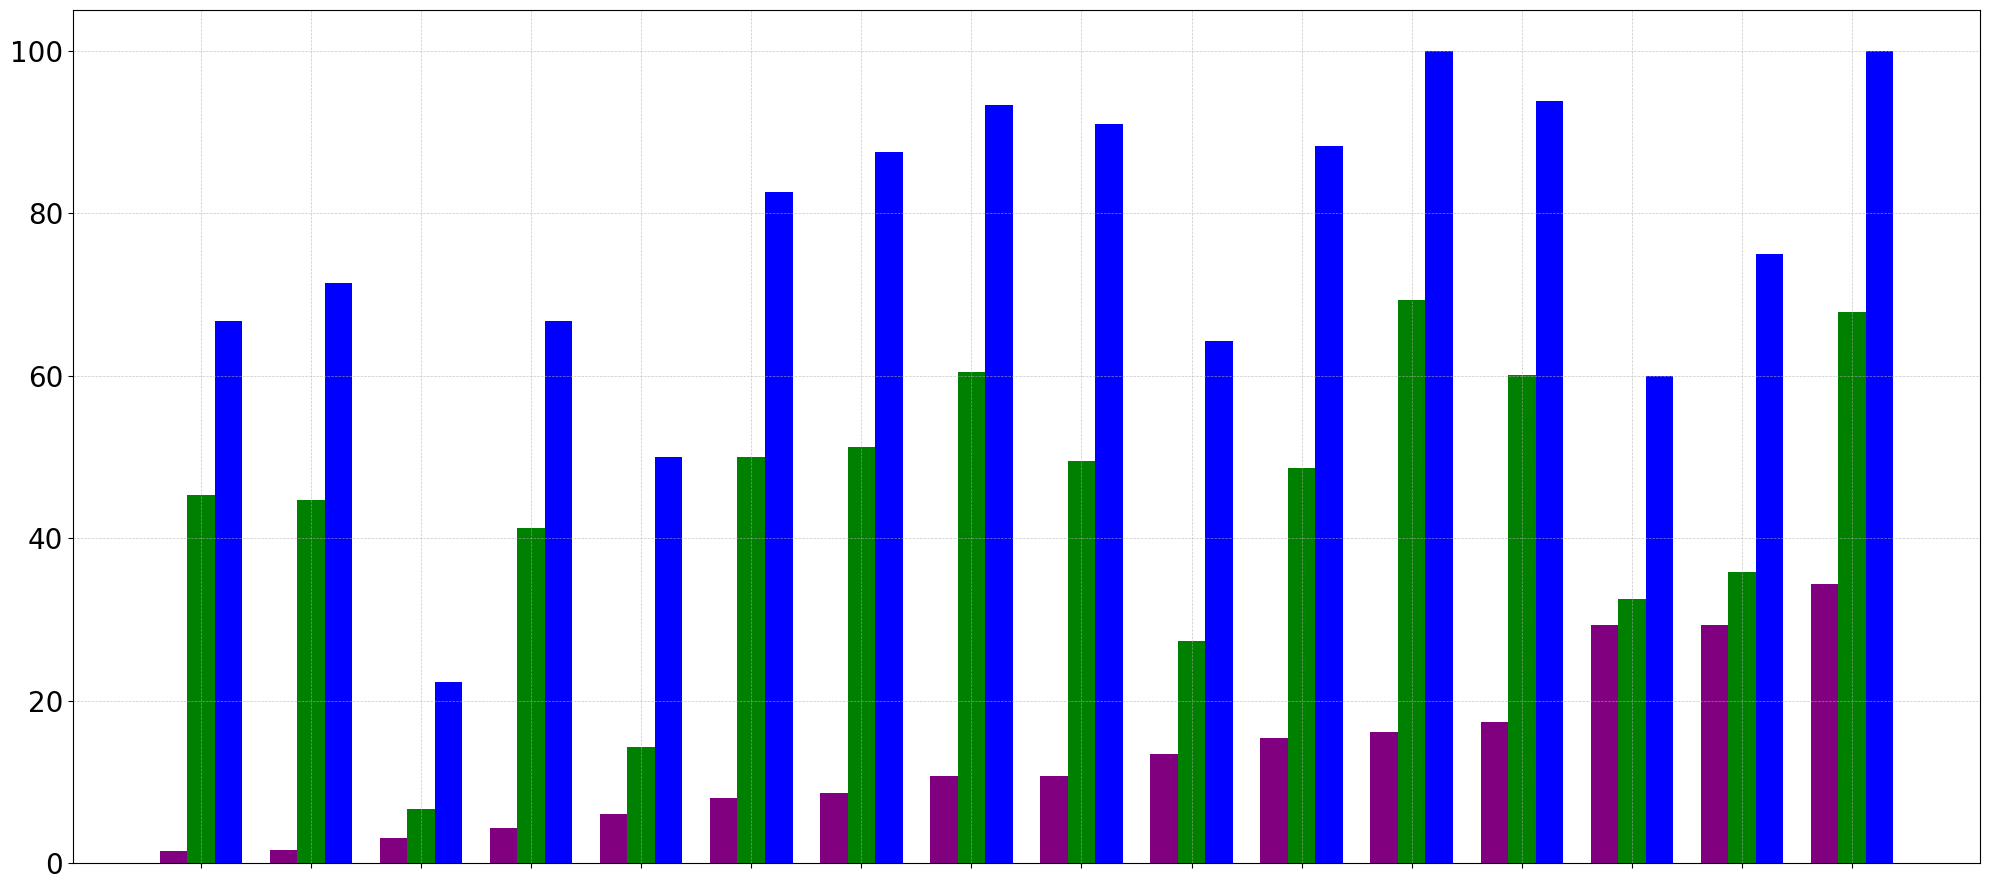

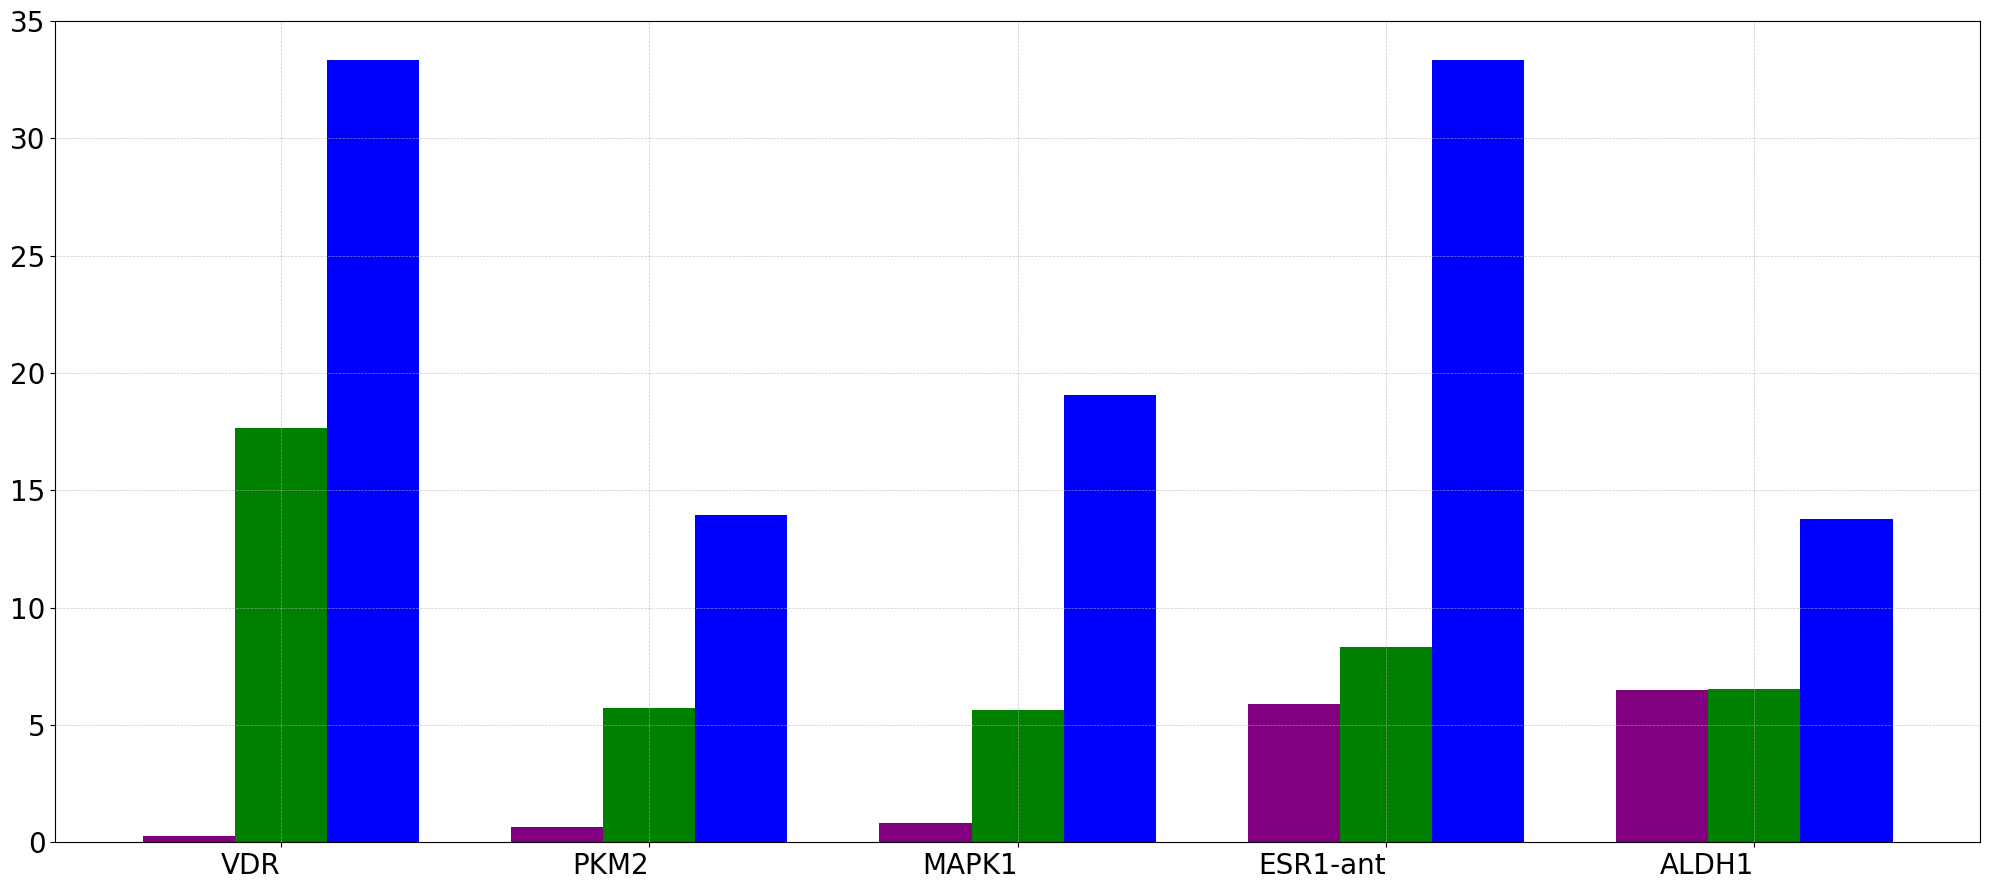

In [ ]:
threshold_value = 5

plot_result_model(chembl_results_dino, figsize=(20, 9), threshold_value=threshold_value)
plot_result_model(
    lit_pcba_results_dino,
    plot_names=True,
    figsize=(20, 9),
    threshold_value=threshold_value,
)

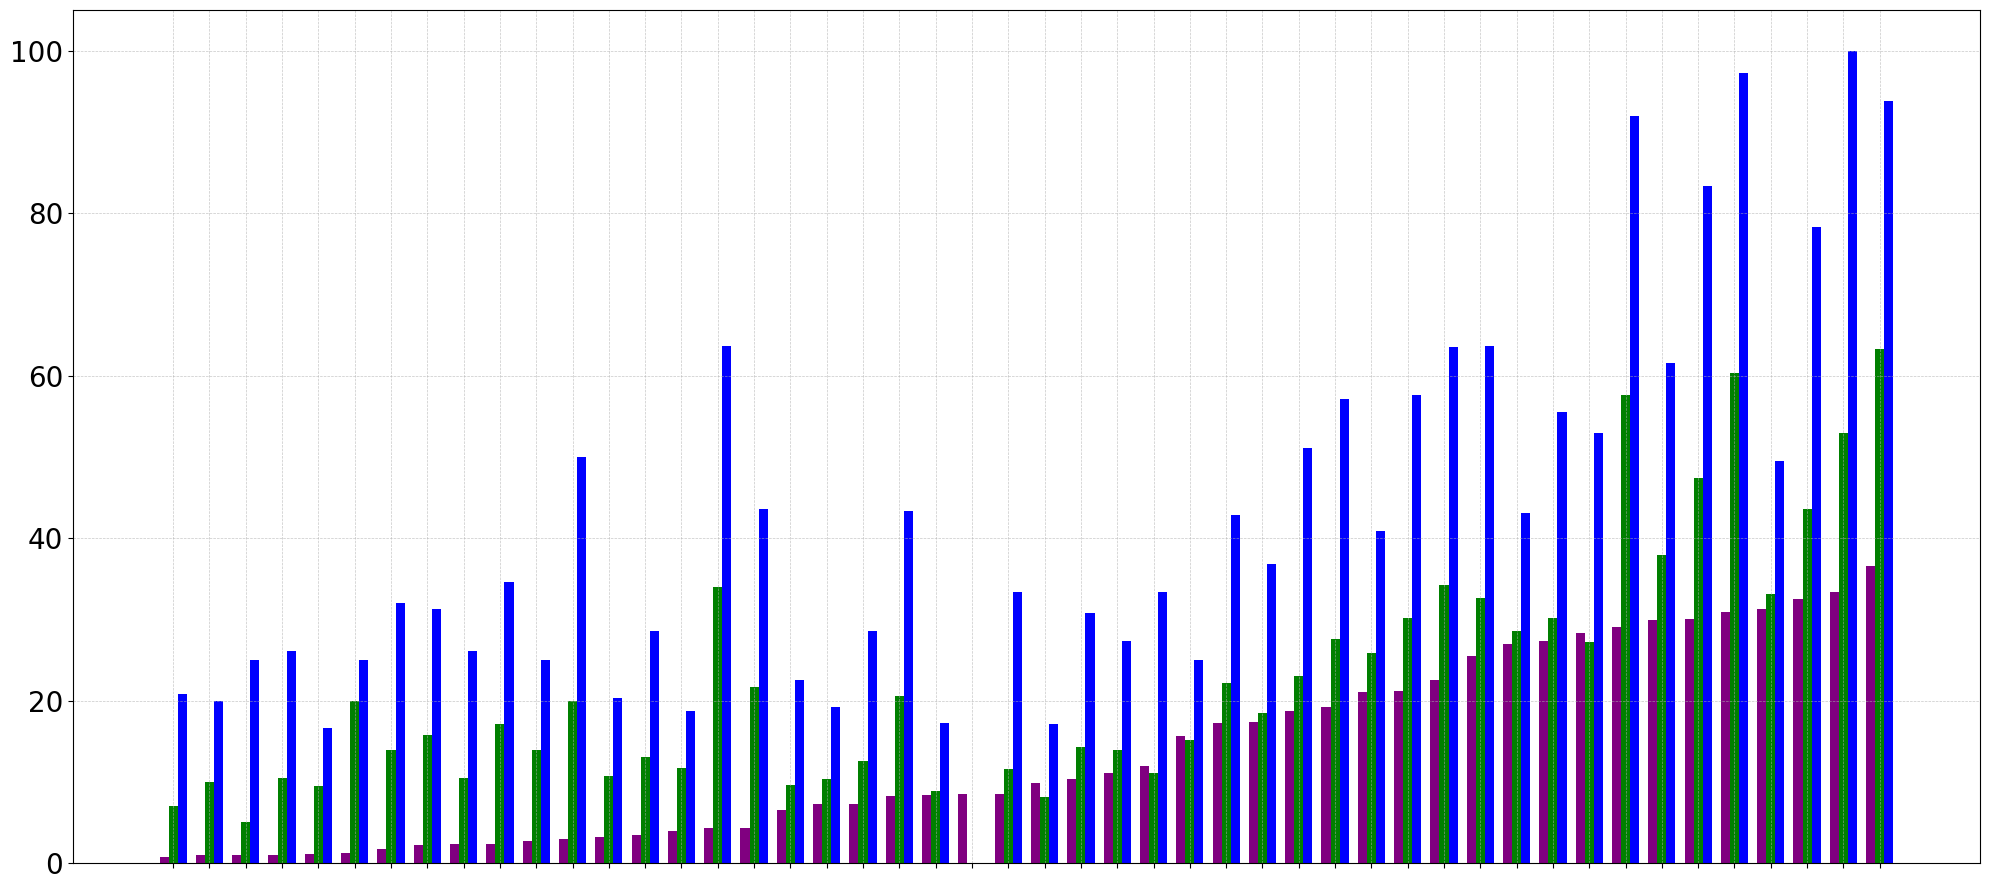

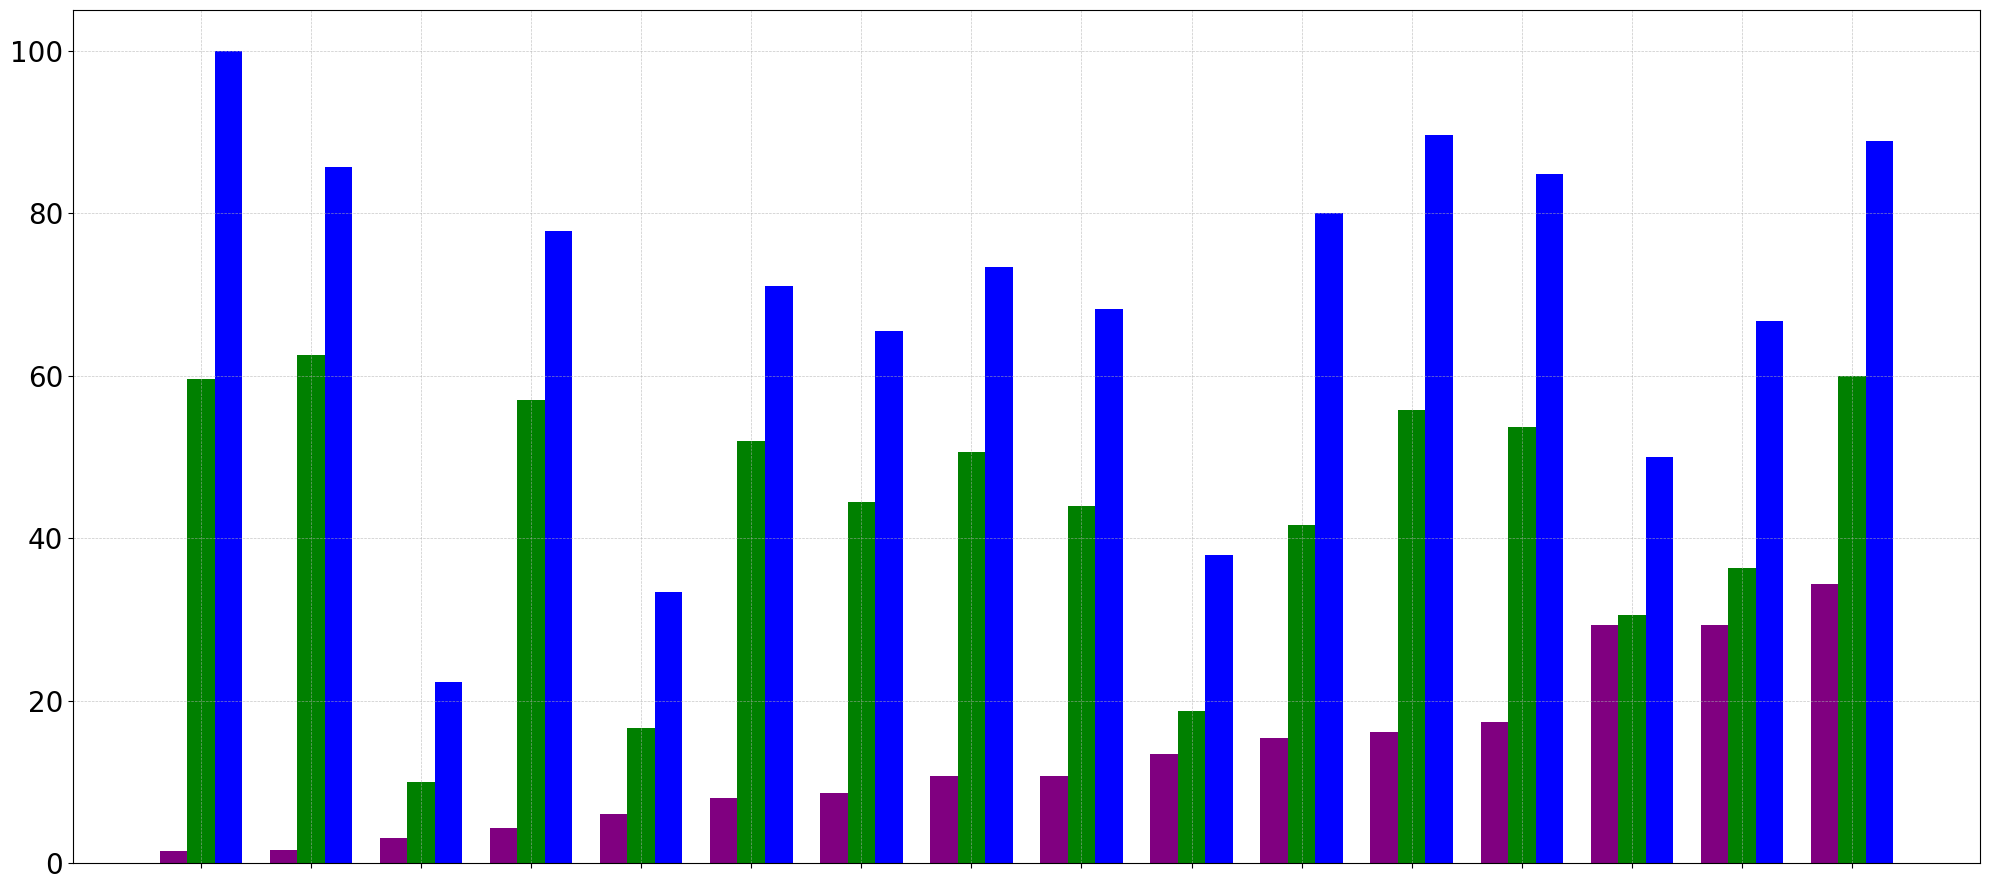

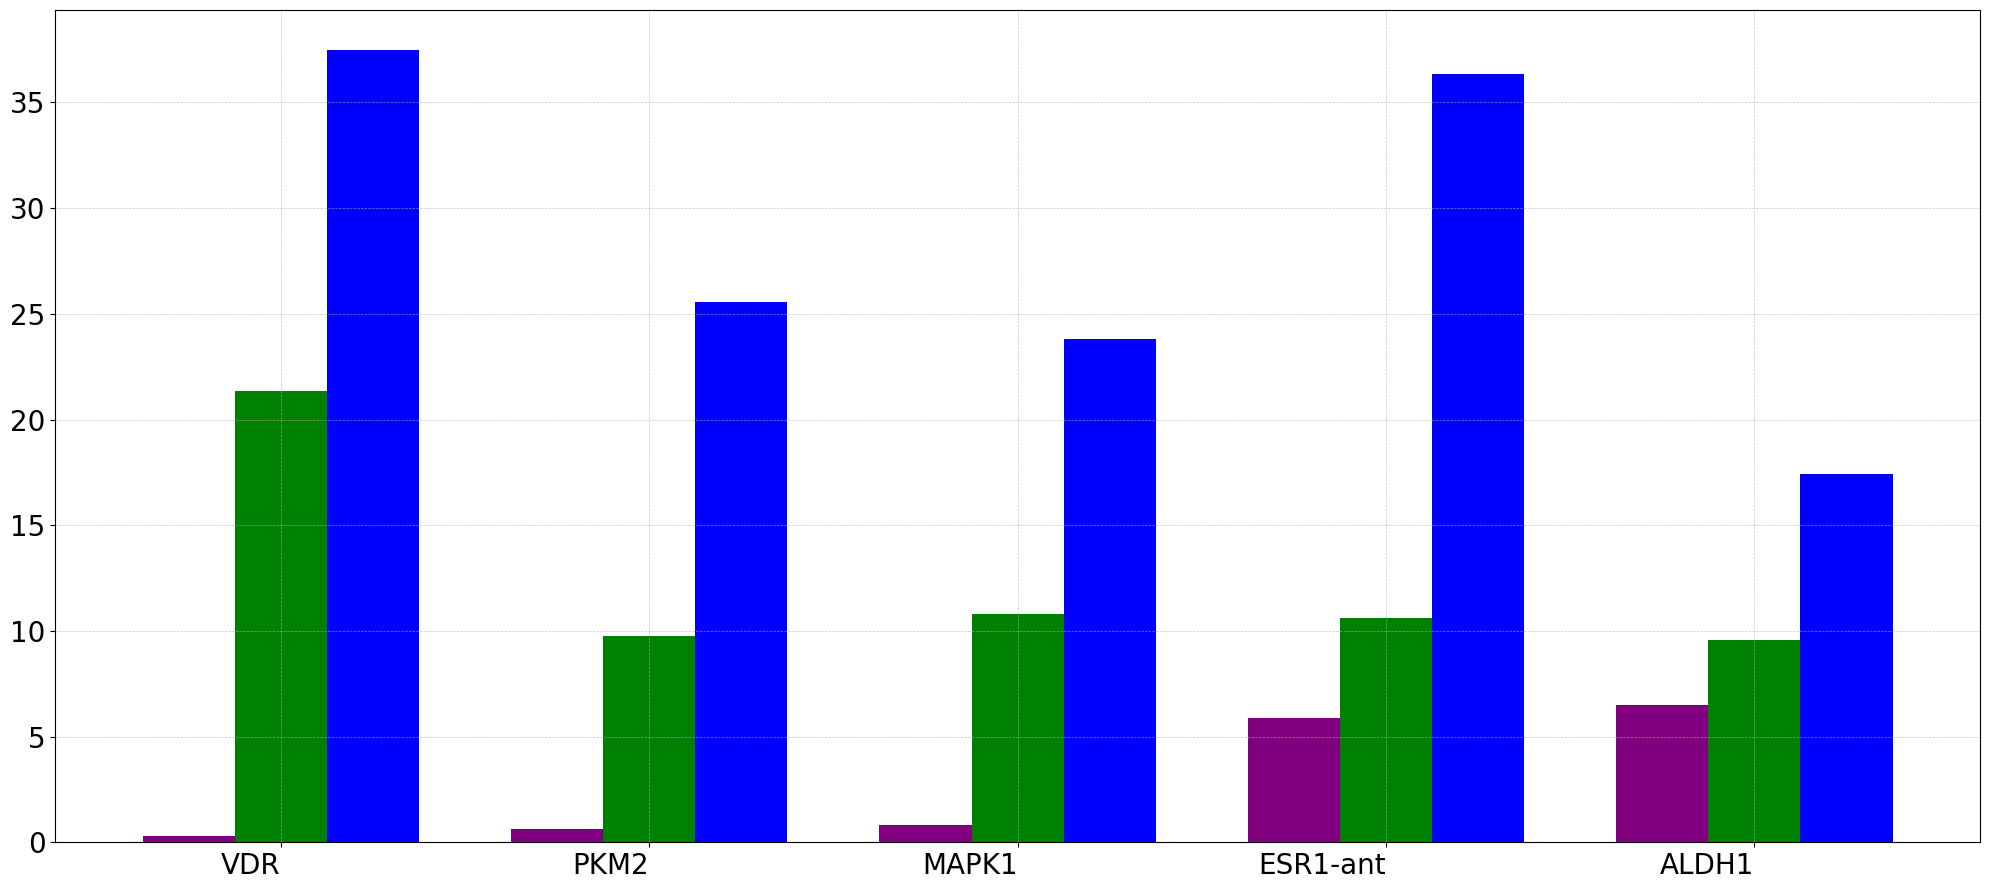

In [ ]:
threshold_value = 10

plot_result_model(chembl_results_dino, figsize=(20, 9), threshold_value=threshold_value)
plot_result_model(
    lit_pcba_results_dino,
    plot_names=True,
    figsize=(20, 9),
    threshold_value=threshold_value,
)

# % of Jump

In [55]:
jcp_chembl = []
for key, em in eval.screen_embedding_managers["ChEMBL"].items():
    jcp_chembl = jcp_chembl + em.df["Metadata_JCP2022"].to_list()
jcp_chembl = set(jcp_chembl)

In [56]:
jcp_litpcba = []
for key, em in eval.screen_embedding_managers["Lit-PCBA"].items():
    jcp_litpcba = jcp_litpcba + em.df["Metadata_JCP2022"].to_list()
jcp_litpcba = set(jcp_litpcba)

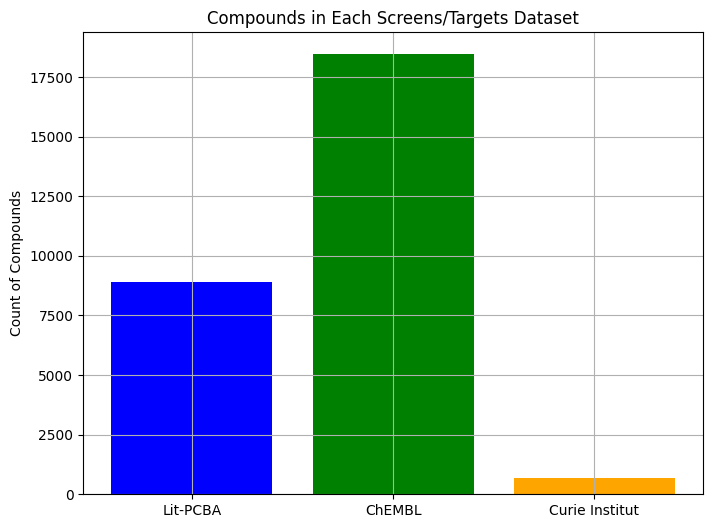

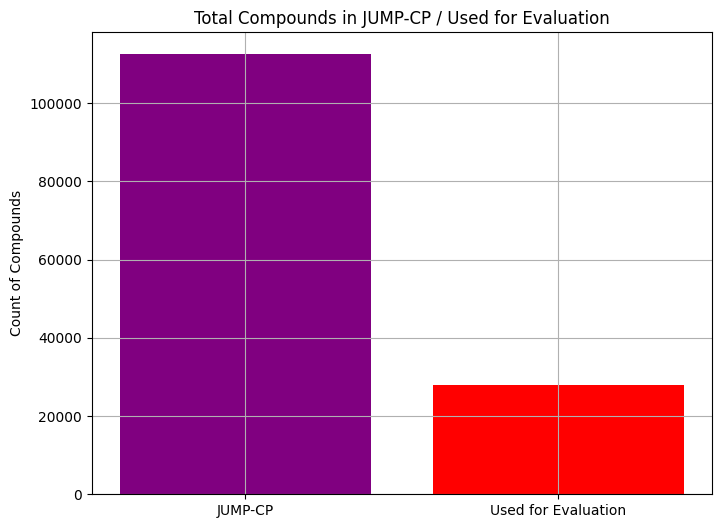

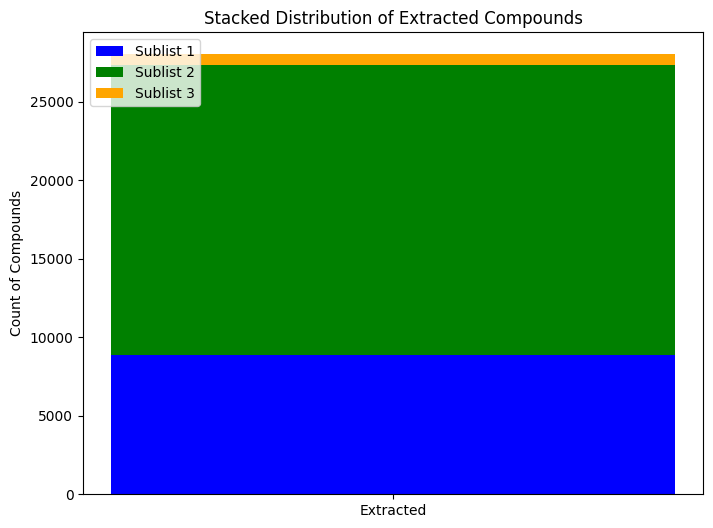

In [ ]:
big_list = set(eval.global_embedding_manager.df["Metadata_JCP2022"].to_list())
sublist1 = jcp_litpcba
sublist2 = jcp_chembl

count_in_big_list_sublist1 = len(sublist1 & big_list)
count_in_big_list_sublist2 = len(sublist2 & big_list)


total_extracted = (
    count_in_big_list_sublist1 + count_in_big_list_sublist2
)


labels = ["Lit-PCBA", "ChEMBL","JUMP-CP"]
counts = [
    count_in_big_list_sublist1,
    count_in_big_list_sublist2,
    total_extracted,
]


fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.bar(labels[:-1], counts[:-1], color=["blue", "green"])
ax1.set_title("Compounds in Each Screens/Targets Dataset")
ax1.grid()
ax1.set_ylabel("Count of Compounds")
plt.show()


fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.bar(
    ["JUMP-CP", "Used for Evaluation"],
    [len(big_list), total_extracted],
    color=["purple", "red"],
)
ax2.grid()
ax2.set_title("Total Compounds in JUMP-CP / Used for Evaluation")
ax2.set_ylabel("Count of Compounds")
plt.show()


fig, ax3 = plt.subplots(figsize=(8, 6))
ax3.bar("Extracted", count_in_big_list_sublist1, color="blue", label="Sublist 1")
ax3.bar(
    "Extracted",
    count_in_big_list_sublist2,
    bottom=count_in_big_list_sublist1,
    color="green",
    label="Sublist 2",
)
ax3.set_title("Stacked Distribution of Extracted Compounds")
ax3.set_ylabel("Count of Compounds")
ax3.legend(loc="upper left")
plt.show()